In [24]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
import lzma
import numpy as np
import matplotlib.pyplot as plt
import random
import json
import pickle
from torch.utils.data import TensorDataset, DataLoader
import itertools
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
from utils.model import deviceof, set_lr_on_step
from utils.env import State, Action, Observation, Transition, state_batch_to_tensor, action_batch_to_tensor, obs_batch_to_tensor
from utils.loader import getFiles
from utils.waymo_loader import extract_scenarios_file

In [26]:
# CHANGE ME: Set this to the path to the Waymo Open Dataset root directory
WAYMO_DATA_PATH = "~/data/waymo"

In [27]:
# load data
with lzma.open("./data/transition_data.pkl.xz", "rb") as f:
    transition_data: list[Transition] = pickle.load(f)

In [7]:
# save data
if not os.path.exists("./data/transition_data.pkl.xz"):
    with lzma.open("./data/transition_data.pkl.xz", "wb") as f:
        pickle.dump(transition_data, f)

In [28]:
# 90:10 train-validation split
transition_train_data = transition_data[:int(len(transition_data)*0.9)]
transition_validation_data = transition_data[int(len(transition_data)*0.9):]

In [29]:
print("train data size:", len(transition_train_data))
print("validation data size:", len(transition_validation_data))

train data size: 450000
validation data size: 50000


In [30]:
# create a model that attempts to predict the next state given the current state and the action: (throttle and steering)
# each state contains: velocity_x, velocity_y, and heading
# creates a model that attempts to predict the action given the current state and the next state
class InverseDynamicsModel(nn.Module):
    def __init__(self):
        super().__init__()
        # input shape: (batch_size, 4, 2)
        # output shape: (batch_size, 2)

        self.conv1 = nn.Conv1d(4, 2048, 2) # Bx4x2 -> Bx768x1
        self.fc1 = nn.Linear(2048, 1536) # Bx768 -> Bx768
        self.fc2 = nn.Linear(1536, 1024) # Bx768 -> Bx768
        self.fc3 = nn.Linear(1024, 768) # Bx768 -> Bx768
        self.fc4 = nn.Linear(768, 2) # Bx768 -> Bx2
    
    def forward(self, x: torch.Tensor):
        x = F.relu(self.conv1(x))
        x = torch.flatten(x, 1)        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        x = torch.clamp(x, -1, 1)
        return x

def idm_train_batch(
        idm: InverseDynamicsModel,
        idm_optimizer: torch.optim.Optimizer,
        obs_tensor: torch.Tensor,
        a_tensor: torch.Tensor,
) -> float:
    device = deviceof(idm)

    obs_tensor = obs_tensor.to(device)
    a_tensor = a_tensor.to(device)

    idm_optimizer.zero_grad()

    pred_action = idm(obs_tensor)

    loss = F.mse_loss(pred_action, a_tensor)
    loss.backward()

    idm_optimizer.step()

    return float(loss.item())

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [36]:
idm_train_dataset = TensorDataset(
    obs_batch_to_tensor([Observation(t.state, t.next_state) for t in transition_train_data], torch.device("cpu")),
    action_batch_to_tensor([t.action for t in transition_train_data], torch.device("cpu")),
)
idm_train_loader = DataLoader(idm_train_dataset, batch_size=8192, shuffle=True)
idm_train_iter = itertools.cycle(iter(idm_train_loader))

idm = InverseDynamicsModel().to(device)

idm_optimizer = torch.optim.AdamW(idm.parameters(), lr=0.0)

idm_step = 0
idm_losses = []

In [42]:
LR_SCHEDULE = {
    0: 1e-3,
    25_000: 5e-4,
    30_000: 2e-4,
    35_000: 1e-4,
    40_000: 5e-5,
    45_000: 2e-5,
    50_000: 1e-5,
}
INVERSE_DYNAMICS_MODEL_TRAIN_EPOCHS = 55_000

while idm_step < INVERSE_DYNAMICS_MODEL_TRAIN_EPOCHS:
    set_lr_on_step(idm_step, idm_optimizer, LR_SCHEDULE)
    obs_tensor, a_tensor = next(idm_train_iter) 
    loss = idm_train_batch(
        idm,
        idm_optimizer,
        obs_tensor,
        a_tensor,
    )
    idm_losses.append(loss)
    idm_step += 1
    if idm_step % 1000 == 0:
        # print average loss over last 100 steps
        loss = np.mean(idm_losses[-1000:])
        print(f"Step: {idm_step}, Loss: {loss:.6f}")

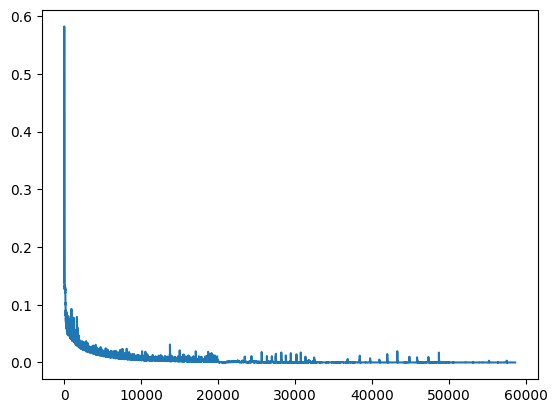

In [43]:
import matplotlib.pyplot as plt

# Plot the losses over training
plt.plot(list(range(len(idm_losses))), idm_losses, label='IDM')
plt.show()

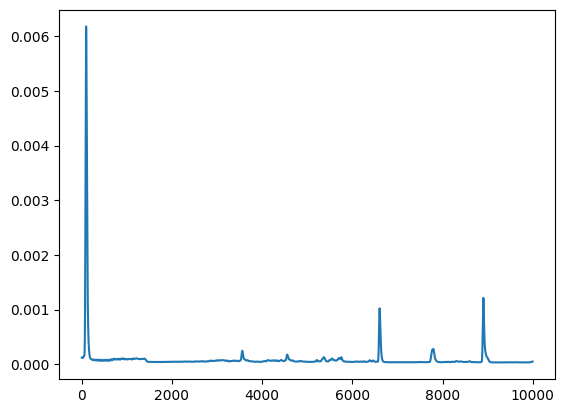

In [44]:
from scipy.ndimage import gaussian_filter1d

# plot the average reward per episode
idm_losses_averaged = gaussian_filter1d(idm_losses[-10000:], sigma=10)
plt.plot(idm_losses_averaged)

In [63]:
# save IDM
if not os.path.exists('./data/idm.pth'):
    torch.save(idm.state_dict(), './data/idm.pth')

In [32]:
# load IDM
if 'idm' not in locals():
    idm = InverseDynamicsModel().to(device)
    idm.load_state_dict(torch.load('./data/idm.pth'))

In [33]:
obs_tensor = obs_batch_to_tensor([Observation(t.state, t.next_state) for t in transition_train_data], device)
a_tensor = action_batch_to_tensor([t.action for t in transition_train_data], device)

with torch.no_grad():
    a_pred_tensor = idm(obs_tensor)

loss = (a_tensor - a_pred_tensor)**2
loss_steer = loss[:, 0].cpu().detach().numpy()
loss_throttle = loss[:, 1].cpu().detach().numpy()

print("training loss", loss.mean().item())

OutOfMemoryError: CUDA out of memory. Tried to allocate 3.43 GiB (GPU 0; 23.69 GiB total capacity; 287.22 MiB already allocated; 1.18 GiB free; 346.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
obs_tensor = obs_batch_to_tensor([Observation(t.state, t.next_state) for t in transition_validation_data], device)
a_tensor = action_batch_to_tensor([t.action for t in transition_validation_data], device)

with torch.no_grad():
    a_pred_tensor = idm(obs_tensor)

loss = (a_tensor - a_pred_tensor)**2
loss_steer = loss[:, 0].cpu().detach().numpy()
loss_throttle = loss[:, 1].cpu().detach().numpy()

print("validation loss", loss.mean().item())

validation loss 5.66789458389394e-05


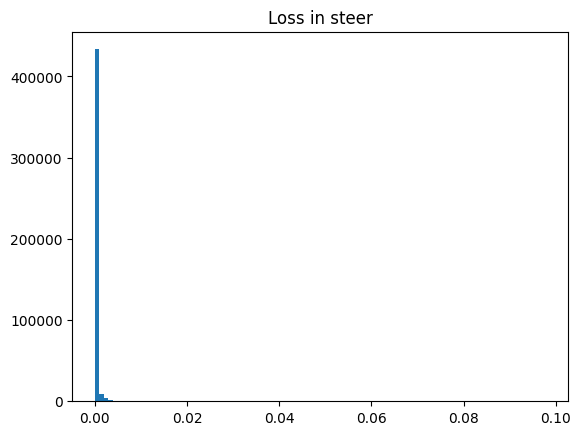

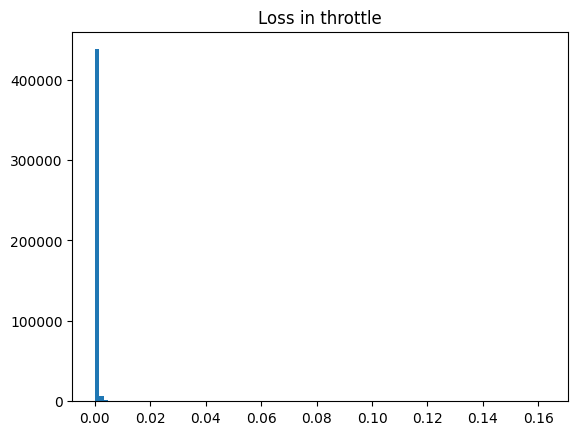

In [ ]:
plt.hist(loss_steer, bins=100)
plt.title('Loss in steer')
plt.show()
plt.hist(loss_throttle, bins=100)
plt.title('Loss in throttle')
plt.show()

In [34]:
class IDMPolicy:
    def __init__(self, net: InverseDynamicsModel):
        self.net = net

    def __call__(self, obs:Observation) -> Action:
        # sample an action from the policy network
        obs_tensor = obs_batch_to_tensor([obs], deviceof(self.net))
        # sample an action from the policy network
        with torch.no_grad():
            steering, throttle = self.net(obs_tensor)[0]
        return Action(steering.item(), throttle.item())

In [61]:
scenarios = extract_scenarios_file(getFiles(WAYMO_DATA_PATH)[0])

2023-09-07 00:14:49.957502: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-07 00:14:50.196104: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-07 00:14:50.196306: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [35]:
# load waymo trained IDM for reference
waymo_idm = InverseDynamicsModel().to(device)
waymo_idm.load_state_dict(torch.load('./data/waymo/idm.pth'))

<All keys matched successfully>

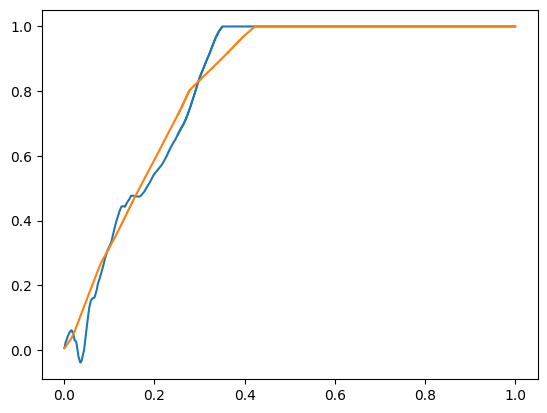

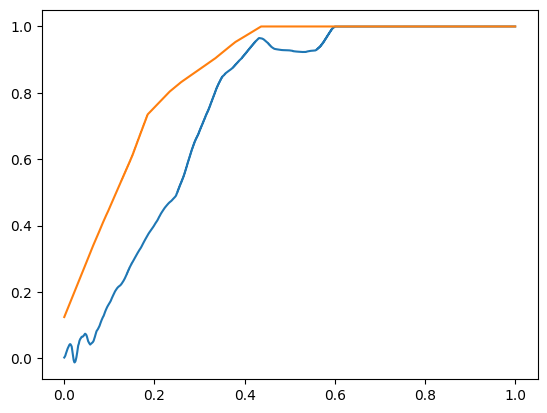

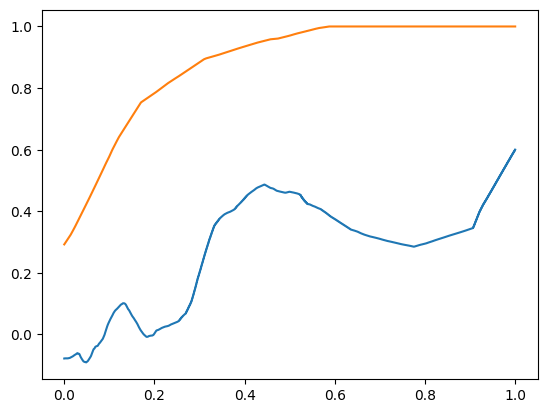

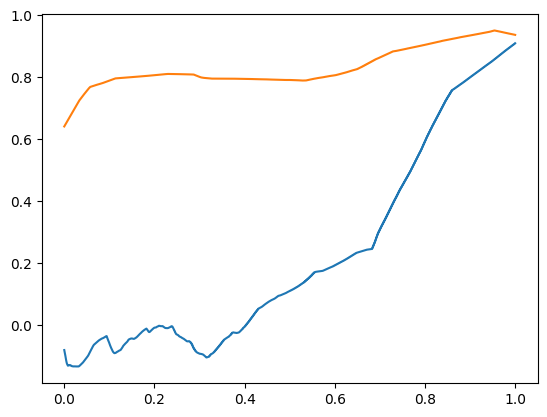

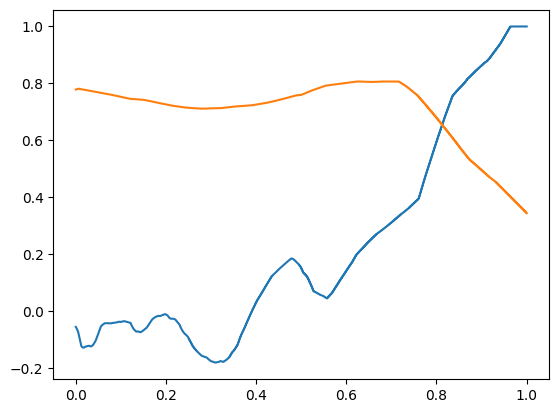

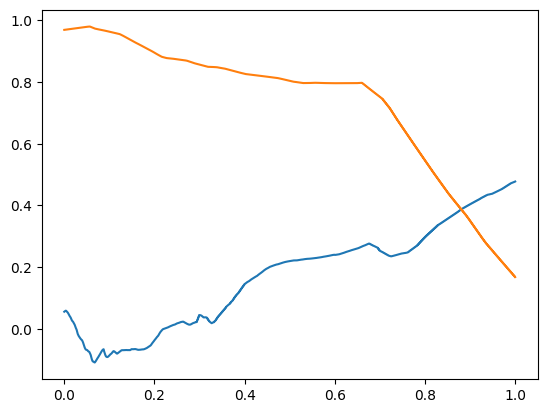

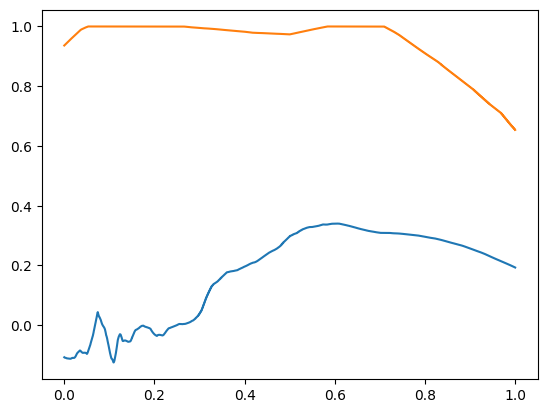

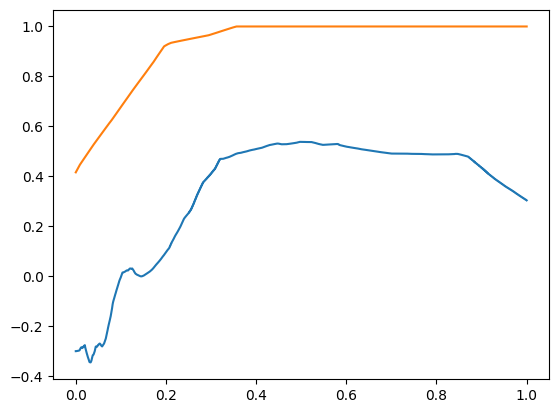

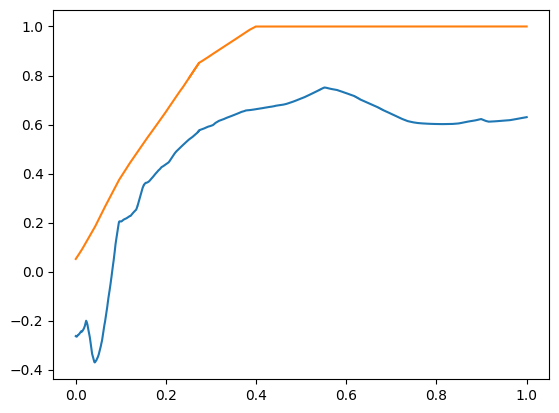

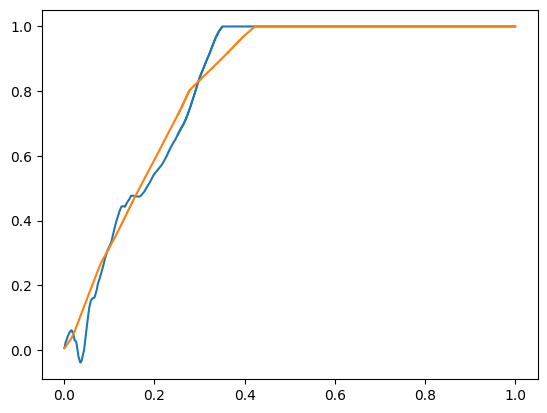

In [45]:
vels = np.linspace([0, 0], [1, 0], 10000)


for h in np.linspace(0, 2*np.pi, 10):
    headings = np.linspace(0, 0, 10000) + h

    obs_batch = obs_batch_to_tensor([Observation(State(0, (0, 0)), State(heading, (x, y))) for (x,y), heading in zip(vels, headings)], device)
    action_batch = idm(obs_batch)
    waymo_action_batch = waymo_idm(obs_batch)

    plt.plot(vels[:, 0], action_batch[:, 1].cpu().detach().numpy(), label='throttle')
    plt.plot(vels[:, 0], waymo_action_batch[:, 1].cpu().detach().numpy(), label='waymo throttle')
    plt.show()